# Analyze the export on hpatches

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/yyjau/Documents/deepSfm_test


## keypoints histogram

In [2]:
# folders
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from imageio import imread
def load_as_float(path):
    return imread(path).astype(np.float32)/255

# folders = ['superpoint_pretrained_hpatches', 'superpoint_coco20_8_170k_hpatches', \
#            'magicpoint_coco_new1_10k_hpatches']
# folders = ['superpoint_coco2_3_hpatches-a4']
folders = ['superpoint_coco40_15_170k_hpatches_nms4_det0.015']
# folders = ['superpoint_pretrained_hpatches', 'superpoint_coco20_5_50k_hpatches']

# parameters
scale = 10
count = 1

base_path = '../logs'
prediction = 'predictions'

print("folders: ", folders)


folders:  ['superpoint_coco40_15_170k_hpatches_nms4_det0.015']


In [3]:
import torch
def getLabels(points_path, img_shape):
    pnts = np.load(points_path)['pts']
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 1], pnts[:, 0]] = 1
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def pnts2img(pnts, img_shape):
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 0], pnts[:, 1]] = 1  # pnts (y,x)
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def warpLabels(pnts, homography, H, W):
    """
    input: 
        pnts: numpy
        homography: numpy
    output:
        warped_pnts: numpy
    """
    from utils.utils import warp_points
    from utils.utils import filter_points
    pnts = torch.tensor(pnts).long()
    homography = torch.tensor(homography, dtype=torch.float32)
    warped_pnts = warp_points(torch.stack((pnts[:, 0], pnts[:, 1]), dim=1),
                                   homography) # check the (x, y)
    warped_pnts = filter_points(warped_pnts, torch.tensor([W, H])).round().long()
    return warped_pnts.numpy()

def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])

    return img

def printImgPnts(image, pnts):
    img_shape = image.shape

    print(img_shape)
    labels_2D, pnts = pnts2img(keypoints, img_shape)
    labels_2D = labels_2D.squeeze().numpy()
    print("labels ", labels_2D.shape)

    img_r = np.zeros_like(image)
    overlap = img_overlap(img_r[np.newaxis,:,:], 
                          labels_2D[np.newaxis,:,:], image[np.newaxis,:,:])
    print(overlap.shape)
    plt.imshow(overlap)
    plt.show()

ModuleNotFoundError: No module named 'torch'

In [4]:
##### edit here

def getNumPoints(data, verbose=False):
    # read data
    image = data['image']
    warped_image = data['warped_image']
    real_H = data['homography']
    keypoints = data['prob'][:,[1, 0]] # (y, x)
    desc = data['desc']
    warped_keypoints = data['warped_prob'][:,[1, 0]]
    if verbose:
        print("keypoints shape: ", keypoints.shape)
        print("desc shape: ", desc.shape)
    
    # unwarp points, filter
    from numpy.linalg import inv
    H, W = image.shape
    unwarped_keypoints = warpLabels(warped_keypoints, inv(real_H), H, W)
    
    # return number of points
    ## average the points in 2 images
    return [keypoints.shape[0], warped_keypoints.shape[0], unwarped_keypoints.shape[0], 
            (keypoints.shape[0]+unwarped_keypoints.shape[0])/2]

In [5]:
# repeatibility

# images_num = 10
# rows = images_num
# cols = len(folders)
# plt.figure(figsize=(cols*2*scale, rows*scale))
# task_folder = ['repeatibility3']
# count = 1

all_num_points = []
for folder in folders:
    num_points = [] # [[keypoints, warped_keypoints, unwarped_keypoints]]
    exp_path = Path(base_path, folder, prediction)
    files = os.listdir( exp_path )
    for f in files:
    #     print("file: ", f)
        if f[-3:] == 'npz':
    #         print("file: ", f)
            data = np.load(exp_path/f)        
            num_points.append(getNumPoints(data))
    #         print("points: ", getNumPoints(data))
    # file =  exp_path / '0.npz'

    num_points = np.array(num_points)
    print(num_points.shape)
    all_num_points.append(num_points)

(580, 4)


In [6]:
def plotHist(vect, title='untitled', label='', range=(0,2000), plot=True):
    import matplotlib.pyplot as plt
    rng = np.random.RandomState(10)  # deterministic random data
#     a = np.hstack((rng.normal(size=1000),
#                    rng.normal(loc=5, scale=2, size=1000)))
    plt.hist(vect, bins='auto', alpha=0.5, histtype='bar', range=range, label=label)  # arguments are passed to np.histogram
    plt.title(title)


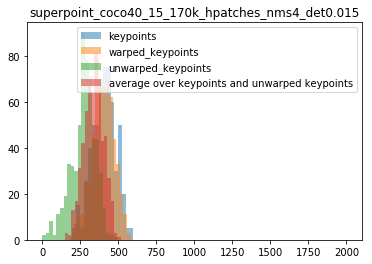

In [7]:
titles = ['keypoints', 'warped_keypoints', 'unwarped_keypoints', 
          'average over keypoints and unwarped keypoints']

for f_idx in range(len(folders)):
    num_points = all_num_points[f_idx]
    for i in range(num_points.shape[1]):
    #     plotHist(num_points[:,i], titles[i], alpha=0.5)
        plotHist(num_points[:,i], label=titles[i], title=folders[f_idx])
    plt.legend(loc='upper right')
    plt.show()


In [8]:
# plot under different threshold


## descriptor distance histogram

In [9]:
# folders = ['superpoint_pretrained_hpatches', 'superpoint_coco20_7_170k_hpatches', \
#            'superpoint_coco20_8_170k_hpatches']
# folders = ['superpoint_coco20_5_50k_hpatches']
print("folders: ", folders)

folders:  ['superpoint_coco40_15_170k_hpatches_nms4_det0.015']


In [10]:
def getInliers(matches, H, epi=3, verbose=False):
    """
    input:
        matches: numpy (n, 4(x1, y1, x2, y2))
        H (ground truth homography): numpy (3, 3)
    """
    from evaluations.detector_evaluation import warp_keypoints
    # warp points 
    warped_points = warp_keypoints(matches[:, :2], H) # make sure the input fits the (x,y)
    
    # compute point distance
    norm = np.linalg.norm(warped_points - matches[:, 2:4],
                            ord=None, axis=1)
    inliers = norm < epi
    if verbose:
        print("Total matches: ", inliers.shape[0], ", inliers: ", inliers.sum(),
                          ", percentage: ", inliers.sum() / inliers.shape[0])
    
    return inliers

def getInliers_cv(matches, H=None, epi=3, verbose=False):
    import cv2
    # count inliers: use opencv homography estimation
    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matches[:, [0, 1]],
                                    matches[:, [2, 3]],
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    print("Total matches: ", inliers.shape[0], ", inliers: ", inliers.sum(),
          ", percentage: ", inliers.sum() / inliers.shape[0])

    return inliers

def getMatches(data, verbose=False):
    # compute all matchings from descriptor
    from models.model_wrap import PointTracker
    %reload_ext autoreload
    %autoreload 2
    
    desc = data['desc']
    warped_desc = data['warped_desc']
    keypoints = data['prob'][:,[1, 0]] # (y, x)
    warped_keypoints = data['warped_prob'][:,[1, 0]]

    nn_thresh = 2
    tracker = PointTracker(max_length=2, nn_thresh=nn_thresh)
    # matches = tracker.nn_match_two_way(desc, warped_desc, nn_)
    tracker.update(keypoints.T, desc.T)
    tracker.update(warped_keypoints.T, warped_desc.T)
    matches = tracker.get_matches().T
    mscores = tracker.get_mscores().T

    # mAP
    # matches = data['matches']
    if verbose:
        print("matches: ", matches.shape)
        print("mscores: ", mscores.shape)
        print("mscore max: ", mscores.max(axis=0))
        print("mscore min: ", mscores.min(axis=0))
        
    return matches, mscores

def select_k_best(points, mask, verbose=False):
    """ Select the k most probable points (and strip their proba).
    points has shape (num_points, 3) where the last coordinate is the proba. """
    sorted_prob = points
    if points.shape[1] > 2:
        # add thresh
        if verbose: print('num of points: ', points.shape)

        sorted_prob = points[mask, :]
        if verbose: print('num of points after thresh: ', sorted_prob.shape)

    return sorted_prob

def dataFilterDetection(data, det_thd=0, verbose=False):
    desc = data['desc']
    warped_desc = data['warped_desc']
    keypoints = data['prob'] # (x, y, prob)
    warped_keypoints = data['warped_prob']
    
    # create new dict
    newData = {}
    newData.update(data)
    
    # image 1
    mask = keypoints[:,2] > det_thd
    temp = select_k_best(desc, mask, verbose=verbose)
    newData.update({'desc': temp})
    temp = select_k_best(keypoints, mask, verbose=verbose)
    newData.update({'prob': temp})
    
    # warped image
    mask = warped_keypoints[:,2] > det_thd
    temp = select_k_best(warped_desc, mask, verbose=verbose)
    newData.update({'warped_desc': temp})
    temp = select_k_best(warped_keypoints, mask, verbose=verbose)
    newData.update({'warped_prob': temp})
    
    return newData
    


def inliersThds(mscore, thd, inliers):
    """
    input:
        mscore: numpy(n1,)
        thd: numpy(t,) # different thresholds
        inliers: numpy (n1,)
    output:
        num of inliers under different thd:
            numpy (t,)
    """
    mscore = mscore.reshape(mscore.shape[0], 1)
    thd = thd.reshape(1, thd.shape[0])
    inliers = inliers.reshape(inliers.shape[0], 1)
    matches = mscore < thd # (n1, t)
    n_matches = matches.sum(axis=0)
#     print("n_m: ", n_matches)
    
    n_inliers = matches*inliers
    
    n_inliers = n_inliers.sum(axis=0)
#     print("n_in: ", n_inliers)

    return n_matches, n_inliers


In [11]:
# det_thd = 0.035
# data_test = dataFilterDetection(data, det_thd=det_thd, verbose=True)

## Compute the analysis
- Remember to empty the array

In [12]:
inliers_exp, matches_exp, mscores_exp = {}, {}, {}

verbose = False
inliers_method = 'cv'
# threshs = np.array([0.7, 0.8, 0.9, 1.0, 1.2])
threshs = np.array([0.1, 0.2, 0.3, 0.4, 0.5,
                    0.6, 0.7, 0.8, 0.9, 1.0,
                    1.1, 1.2, 1.3, 1.4, 1.5,
                    1.6, 1.7, 1.8, 1.9, 2.0])
m_count = 600
det_thd = 0.015 # 0.105
all_num_points = []
print("det threshold: ", det_thd)

for folder in folders:
    print("work on ", folder)
    num_points = [] # [[keypoints, warped_keypoints, unwarped_keypoints]]
    exp_path = Path(base_path, folder, prediction)
    files = os.listdir( exp_path )
    # empty stackes
    count = 0
    inliers_all = [] 
    matches_all = []
    mscores_all = []
    inliersThds_all = []
    matchesThds_all = []
    p_inliers_all = []
    for f in files:
    #     print("file: ", f)
        if f[-3:] == 'npz':
            data = np.load(exp_path/f)   
            # filter points
            data = dataFilterDetection(data, det_thd=det_thd, verbose=True)
            
            # compute matches
            matches, mscores = getMatches(data, verbose=verbose)
            real_H = data['homography']
            
            if inliers_method == 'gt':
                # use ground truth homography
                print("use ground truth homography for inliers")
                inliers = getInliers(matches, real_H, epi=3, verbose=verbose)
            else:
                # use opencv estimation as inliers
                print("use opencv estimation for inliers")
                inliers = getInliers_cv(matches, real_H, epi=3, verbose=verbose)
            
            
#             print("inliers: ", inliers)
            num_points.append(getNumPoints(data))
            
            n_matches, n_inliers = inliersThds(mscores[:,2], threshs, inliers)
            
            p_inliers = np.divide(n_inliers, n_matches + 0.0001)
            if verbose:
                print("inliers: ", n_inliers)
                print("matches: ", n_matches)
                print("p_inliers: ", p_inliers)
            
            matches_all.append(matches)
            mscores_all.append(mscores)
            inliers_all.append(inliers)
            inliersThds_all.append(n_inliers)
            matchesThds_all.append(n_matches)
            p_inliers_all.append(p_inliers)
            
        if count == m_count:
            break
        count += 1
#     inliers_exp.update({folder: inliers_all})
#     matches_exp.update({folder: matches_all})
#     mscores_exp.update({folder: mscores_all})
    exp_results = {'matches_all': matches_all, 'mscores_all': mscores_all, 'inliers_all': inliers_all,
                  'inliersThds_all': inliersThds_all, 'matchesThds_all': matchesThds_all,
                  'p_inliers_all': p_inliers_all}
    inliers_exp.update({folder: exp_results})
    
    
    num_points = np.array(num_points)
    print(num_points.shape)
    all_num_points.append(num_points)

det threshold:  0.015
work on  superpoint_coco40_15_170k_hpatches_nms4_det0.015
num of points:  (456, 256)
num of points after thresh:  (456, 256)
num of points:  (456, 3)
num of points after thresh:  (456, 3)
num of points:  (488, 256)
num of points after thresh:  (488, 256)
num of points:  (488, 3)
num of points after thresh:  (488, 3)
use opencv estimation for inliers
Total matches:  175 , inliers:  79 , percentage:  0.4514285714285714
num of points:  (288, 256)
num of points after thresh:  (288, 256)
num of points:  (288, 3)
num of points after thresh:  (288, 3)
num of points:  (361, 256)
num of points after thresh:  (361, 256)
num of points:  (361, 3)
num of points after thresh:  (361, 3)
use opencv estimation for inliers
Total matches:  144 , inliers:  67 , percentage:  0.4652777777777778
num of points:  (335, 256)
num of points after thresh:  (335, 256)
num of points:  (335, 3)
num of points after thresh:  (335, 3)
num of points:  (326, 256)
num of points after thresh:  (326, 25

num of points:  (517, 256)
num of points after thresh:  (517, 256)
num of points:  (517, 3)
num of points after thresh:  (517, 3)
num of points:  (364, 256)
num of points after thresh:  (364, 256)
num of points:  (364, 3)
num of points after thresh:  (364, 3)
use opencv estimation for inliers
Total matches:  159 , inliers:  66 , percentage:  0.41509433962264153
num of points:  (356, 256)
num of points after thresh:  (356, 256)
num of points:  (356, 3)
num of points after thresh:  (356, 3)
num of points:  (368, 256)
num of points after thresh:  (368, 256)
num of points:  (368, 3)
num of points after thresh:  (368, 3)
use opencv estimation for inliers
Total matches:  164 , inliers:  79 , percentage:  0.4817073170731707
num of points:  (422, 256)
num of points after thresh:  (422, 256)
num of points:  (422, 3)
num of points after thresh:  (422, 3)
num of points:  (444, 256)
num of points after thresh:  (444, 256)
num of points:  (444, 3)
num of points after thresh:  (444, 3)
use opencv es

num of points:  (390, 256)
num of points after thresh:  (390, 256)
num of points:  (390, 3)
num of points after thresh:  (390, 3)
num of points:  (392, 256)
num of points after thresh:  (392, 256)
num of points:  (392, 3)
num of points after thresh:  (392, 3)
use opencv estimation for inliers
Total matches:  178 , inliers:  94 , percentage:  0.5280898876404494
num of points:  (422, 256)
num of points after thresh:  (422, 256)
num of points:  (422, 3)
num of points after thresh:  (422, 3)
num of points:  (424, 256)
num of points after thresh:  (424, 256)
num of points:  (424, 3)
num of points after thresh:  (424, 3)
use opencv estimation for inliers
Total matches:  169 , inliers:  74 , percentage:  0.4378698224852071
num of points:  (379, 256)
num of points after thresh:  (379, 256)
num of points:  (379, 3)
num of points after thresh:  (379, 3)
num of points:  (361, 256)
num of points after thresh:  (361, 256)
num of points:  (361, 3)
num of points after thresh:  (361, 3)
use opencv est

use opencv estimation for inliers
Total matches:  425 , inliers:  392 , percentage:  0.9223529411764706
num of points:  (328, 256)
num of points after thresh:  (328, 256)
num of points:  (328, 3)
num of points after thresh:  (328, 3)
num of points:  (352, 256)
num of points after thresh:  (352, 256)
num of points:  (352, 3)
num of points after thresh:  (352, 3)
use opencv estimation for inliers
Total matches:  252 , inliers:  176 , percentage:  0.6984126984126984
num of points:  (335, 256)
num of points after thresh:  (335, 256)
num of points:  (335, 3)
num of points after thresh:  (335, 3)
num of points:  (334, 256)
num of points after thresh:  (334, 256)
num of points:  (334, 3)
num of points after thresh:  (334, 3)
use opencv estimation for inliers
Total matches:  205 , inliers:  186 , percentage:  0.9073170731707317
num of points:  (577, 256)
num of points after thresh:  (577, 256)
num of points:  (577, 3)
num of points after thresh:  (577, 3)
num of points:  (524, 256)
num of poin

num of points after thresh:  (394, 256)
num of points:  (394, 3)
num of points after thresh:  (394, 3)
num of points:  (392, 256)
num of points after thresh:  (392, 256)
num of points:  (392, 3)
num of points after thresh:  (392, 3)
use opencv estimation for inliers
Total matches:  252 , inliers:  213 , percentage:  0.8452380952380952
num of points:  (457, 256)
num of points after thresh:  (457, 256)
num of points:  (457, 3)
num of points after thresh:  (457, 3)
num of points:  (518, 256)
num of points after thresh:  (518, 256)
num of points:  (518, 3)
num of points after thresh:  (518, 3)
use opencv estimation for inliers
Total matches:  236 , inliers:  106 , percentage:  0.4491525423728814
num of points:  (436, 256)
num of points after thresh:  (436, 256)
num of points:  (436, 3)
num of points after thresh:  (436, 3)
num of points:  (436, 256)
num of points after thresh:  (436, 256)
num of points:  (436, 3)
num of points after thresh:  (436, 3)
use opencv estimation for inliers
Total

num of points:  (486, 256)
num of points after thresh:  (486, 256)
num of points:  (486, 3)
num of points after thresh:  (486, 3)
num of points:  (432, 256)
num of points after thresh:  (432, 256)
num of points:  (432, 3)
num of points after thresh:  (432, 3)
use opencv estimation for inliers
Total matches:  171 , inliers:  58 , percentage:  0.3391812865497076
num of points:  (306, 256)
num of points after thresh:  (306, 256)
num of points:  (306, 3)
num of points after thresh:  (306, 3)
num of points:  (256, 256)
num of points after thresh:  (256, 256)
num of points:  (256, 3)
num of points after thresh:  (256, 3)
use opencv estimation for inliers
Total matches:  85 , inliers:  17 , percentage:  0.2
num of points:  (425, 256)
num of points after thresh:  (425, 256)
num of points:  (425, 3)
num of points after thresh:  (425, 3)
num of points:  (429, 256)
num of points after thresh:  (429, 256)
num of points:  (429, 3)
num of points after thresh:  (429, 3)
use opencv estimation for inli

num of points:  (279, 256)
num of points after thresh:  (279, 256)
num of points:  (279, 3)
num of points after thresh:  (279, 3)
num of points:  (410, 256)
num of points after thresh:  (410, 256)
num of points:  (410, 3)
num of points after thresh:  (410, 3)
use opencv estimation for inliers
Total matches:  117 , inliers:  6 , percentage:  0.05128205128205128
num of points:  (305, 256)
num of points after thresh:  (305, 256)
num of points:  (305, 3)
num of points after thresh:  (305, 3)
num of points:  (321, 256)
num of points after thresh:  (321, 256)
num of points:  (321, 3)
num of points after thresh:  (321, 3)
use opencv estimation for inliers
Total matches:  135 , inliers:  77 , percentage:  0.5703703703703704
num of points:  (485, 256)
num of points after thresh:  (485, 256)
num of points:  (485, 3)
num of points after thresh:  (485, 3)
num of points:  (431, 256)
num of points after thresh:  (431, 256)
num of points:  (431, 3)
num of points after thresh:  (431, 3)
use opencv est

use opencv estimation for inliers
Total matches:  311 , inliers:  201 , percentage:  0.6463022508038585
num of points:  (512, 256)
num of points after thresh:  (512, 256)
num of points:  (512, 3)
num of points after thresh:  (512, 3)
num of points:  (433, 256)
num of points after thresh:  (433, 256)
num of points:  (433, 3)
num of points after thresh:  (433, 3)
use opencv estimation for inliers
Total matches:  171 , inliers:  48 , percentage:  0.2807017543859649
num of points:  (389, 256)
num of points after thresh:  (389, 256)
num of points:  (389, 3)
num of points after thresh:  (389, 3)
num of points:  (395, 256)
num of points after thresh:  (395, 256)
num of points:  (395, 3)
num of points after thresh:  (395, 3)
use opencv estimation for inliers
Total matches:  294 , inliers:  254 , percentage:  0.8639455782312925
num of points:  (506, 256)
num of points after thresh:  (506, 256)
num of points:  (506, 3)
num of points after thresh:  (506, 3)
num of points:  (459, 256)
num of point

use opencv estimation for inliers
Total matches:  149 , inliers:  99 , percentage:  0.6644295302013423
num of points:  (400, 256)
num of points after thresh:  (400, 256)
num of points:  (400, 3)
num of points after thresh:  (400, 3)
num of points:  (381, 256)
num of points after thresh:  (381, 256)
num of points:  (381, 3)
num of points after thresh:  (381, 3)
use opencv estimation for inliers
Total matches:  316 , inliers:  278 , percentage:  0.879746835443038
num of points:  (345, 256)
num of points after thresh:  (345, 256)
num of points:  (345, 3)
num of points after thresh:  (345, 3)
num of points:  (387, 256)
num of points after thresh:  (387, 256)
num of points:  (387, 3)
num of points after thresh:  (387, 3)
use opencv estimation for inliers
Total matches:  197 , inliers:  131 , percentage:  0.6649746192893401
num of points:  (279, 256)
num of points after thresh:  (279, 256)
num of points:  (279, 3)
num of points after thresh:  (279, 3)
num of points:  (363, 256)
num of points

num of points:  (454, 256)
num of points after thresh:  (454, 256)
num of points:  (454, 3)
num of points after thresh:  (454, 3)
num of points:  (436, 256)
num of points after thresh:  (436, 256)
num of points:  (436, 3)
num of points after thresh:  (436, 3)
use opencv estimation for inliers
Total matches:  269 , inliers:  155 , percentage:  0.5762081784386617
num of points:  (237, 256)
num of points after thresh:  (237, 256)
num of points:  (237, 3)
num of points after thresh:  (237, 3)
num of points:  (319, 256)
num of points after thresh:  (319, 256)
num of points:  (319, 3)
num of points after thresh:  (319, 3)
use opencv estimation for inliers
Total matches:  90 , inliers:  23 , percentage:  0.25555555555555554
num of points:  (336, 256)
num of points after thresh:  (336, 256)
num of points:  (336, 3)
num of points after thresh:  (336, 3)
num of points:  (343, 256)
num of points after thresh:  (343, 256)
num of points:  (343, 3)
num of points after thresh:  (343, 3)
use opencv es

use opencv estimation for inliers
Total matches:  173 , inliers:  32 , percentage:  0.18497109826589594
num of points:  (391, 256)
num of points after thresh:  (391, 256)
num of points:  (391, 3)
num of points after thresh:  (391, 3)
num of points:  (381, 256)
num of points after thresh:  (381, 256)
num of points:  (381, 3)
num of points after thresh:  (381, 3)
use opencv estimation for inliers
Total matches:  155 , inliers:  57 , percentage:  0.36774193548387096
num of points:  (343, 256)
num of points after thresh:  (343, 256)
num of points:  (343, 3)
num of points after thresh:  (343, 3)
num of points:  (334, 256)
num of points after thresh:  (334, 256)
num of points:  (334, 3)
num of points after thresh:  (334, 3)
use opencv estimation for inliers
Total matches:  186 , inliers:  140 , percentage:  0.7526881720430108
num of points:  (410, 256)
num of points after thresh:  (410, 256)
num of points:  (410, 3)
num of points after thresh:  (410, 3)
num of points:  (391, 256)
num of poin

Total matches:  120 , inliers:  14 , percentage:  0.11666666666666667
num of points:  (412, 256)
num of points after thresh:  (412, 256)
num of points:  (412, 3)
num of points after thresh:  (412, 3)
num of points:  (422, 256)
num of points after thresh:  (422, 256)
num of points:  (422, 3)
num of points after thresh:  (422, 3)
use opencv estimation for inliers
Total matches:  243 , inliers:  199 , percentage:  0.8189300411522634
num of points:  (418, 256)
num of points after thresh:  (418, 256)
num of points:  (418, 3)
num of points after thresh:  (418, 3)
num of points:  (340, 256)
num of points after thresh:  (340, 256)
num of points:  (340, 3)
num of points after thresh:  (340, 3)
use opencv estimation for inliers
Total matches:  123 , inliers:  21 , percentage:  0.17073170731707318
num of points:  (545, 256)
num of points after thresh:  (545, 256)
num of points:  (545, 3)
num of points after thresh:  (545, 3)
num of points:  (452, 256)
num of points after thresh:  (452, 256)
num o

num of points:  (377, 256)
num of points after thresh:  (377, 256)
num of points:  (377, 3)
num of points after thresh:  (377, 3)
num of points:  (339, 256)
num of points after thresh:  (339, 256)
num of points:  (339, 3)
num of points after thresh:  (339, 3)
use opencv estimation for inliers
Total matches:  155 , inliers:  65 , percentage:  0.41935483870967744
num of points:  (421, 256)
num of points after thresh:  (421, 256)
num of points:  (421, 3)
num of points after thresh:  (421, 3)
num of points:  (415, 256)
num of points after thresh:  (415, 256)
num of points:  (415, 3)
num of points after thresh:  (415, 3)
use opencv estimation for inliers
Total matches:  282 , inliers:  230 , percentage:  0.8156028368794326
num of points:  (304, 256)
num of points after thresh:  (304, 256)
num of points:  (304, 3)
num of points after thresh:  (304, 3)
num of points:  (293, 256)
num of points after thresh:  (293, 256)
num of points:  (293, 3)
num of points after thresh:  (293, 3)
use opencv e

use opencv estimation for inliers
Total matches:  256 , inliers:  160 , percentage:  0.625
num of points:  (523, 256)
num of points after thresh:  (523, 256)
num of points:  (523, 3)
num of points after thresh:  (523, 3)
num of points:  (488, 256)
num of points after thresh:  (488, 256)
num of points:  (488, 3)
num of points after thresh:  (488, 3)
use opencv estimation for inliers
Total matches:  213 , inliers:  78 , percentage:  0.36619718309859156
num of points:  (396, 256)
num of points after thresh:  (396, 256)
num of points:  (396, 3)
num of points after thresh:  (396, 3)
num of points:  (423, 256)
num of points after thresh:  (423, 256)
num of points:  (423, 3)
num of points after thresh:  (423, 3)
use opencv estimation for inliers
Total matches:  158 , inliers:  57 , percentage:  0.36075949367088606
num of points:  (487, 256)
num of points after thresh:  (487, 256)
num of points:  (487, 3)
num of points after thresh:  (487, 3)
num of points:  (460, 256)
num of points after thre

num of points:  (385, 256)
num of points after thresh:  (385, 256)
num of points:  (385, 3)
num of points after thresh:  (385, 3)
num of points:  (378, 256)
num of points after thresh:  (378, 256)
num of points:  (378, 3)
num of points after thresh:  (378, 3)
use opencv estimation for inliers
Total matches:  280 , inliers:  236 , percentage:  0.8428571428571429
num of points:  (528, 256)
num of points after thresh:  (528, 256)
num of points:  (528, 3)
num of points after thresh:  (528, 3)
num of points:  (503, 256)
num of points after thresh:  (503, 256)
num of points:  (503, 3)
num of points after thresh:  (503, 3)
use opencv estimation for inliers
Total matches:  240 , inliers:  152 , percentage:  0.6333333333333333
num of points:  (452, 256)
num of points after thresh:  (452, 256)
num of points:  (452, 3)
num of points after thresh:  (452, 3)
num of points:  (334, 256)
num of points after thresh:  (334, 256)
num of points:  (334, 3)
num of points after thresh:  (334, 3)
use opencv e

Total matches:  119 , inliers:  10 , percentage:  0.08403361344537816
num of points:  (412, 256)
num of points after thresh:  (412, 256)
num of points:  (412, 3)
num of points after thresh:  (412, 3)
num of points:  (394, 256)
num of points after thresh:  (394, 256)
num of points:  (394, 3)
num of points after thresh:  (394, 3)
use opencv estimation for inliers
Total matches:  191 , inliers:  122 , percentage:  0.6387434554973822
num of points:  (380, 256)
num of points after thresh:  (380, 256)
num of points:  (380, 3)
num of points after thresh:  (380, 3)
num of points:  (399, 256)
num of points after thresh:  (399, 256)
num of points:  (399, 3)
num of points after thresh:  (399, 3)
use opencv estimation for inliers
Total matches:  304 , inliers:  283 , percentage:  0.930921052631579
num of points:  (429, 256)
num of points after thresh:  (429, 256)
num of points:  (429, 3)
num of points after thresh:  (429, 3)
num of points:  (366, 256)
num of points after thresh:  (366, 256)
num of

Total matches:  164 , inliers:  82 , percentage:  0.5
num of points:  (364, 256)
num of points after thresh:  (364, 256)
num of points:  (364, 3)
num of points after thresh:  (364, 3)
num of points:  (281, 256)
num of points after thresh:  (281, 256)
num of points:  (281, 3)
num of points after thresh:  (281, 3)
use opencv estimation for inliers
Total matches:  143 , inliers:  81 , percentage:  0.5664335664335665
num of points:  (349, 256)
num of points after thresh:  (349, 256)
num of points:  (349, 3)
num of points after thresh:  (349, 3)
num of points:  (357, 256)
num of points after thresh:  (357, 256)
num of points:  (357, 3)
num of points after thresh:  (357, 3)
use opencv estimation for inliers
Total matches:  309 , inliers:  306 , percentage:  0.9902912621359223
num of points:  (422, 256)
num of points after thresh:  (422, 256)
num of points:  (422, 3)
num of points after thresh:  (422, 3)
num of points:  (412, 256)
num of points after thresh:  (412, 256)
num of points:  (412, 

Total matches:  135 , inliers:  6 , percentage:  0.044444444444444446
num of points:  (470, 256)
num of points after thresh:  (470, 256)
num of points:  (470, 3)
num of points after thresh:  (470, 3)
num of points:  (426, 256)
num of points after thresh:  (426, 256)
num of points:  (426, 3)
num of points after thresh:  (426, 3)
use opencv estimation for inliers
Total matches:  203 , inliers:  138 , percentage:  0.6798029556650246
num of points:  (397, 256)
num of points after thresh:  (397, 256)
num of points:  (397, 3)
num of points after thresh:  (397, 3)
num of points:  (380, 256)
num of points after thresh:  (380, 256)
num of points:  (380, 3)
num of points after thresh:  (380, 3)
use opencv estimation for inliers
Total matches:  169 , inliers:  113 , percentage:  0.6686390532544378
num of points:  (431, 256)
num of points after thresh:  (431, 256)
num of points:  (431, 3)
num of points after thresh:  (431, 3)
num of points:  (465, 256)
num of points after thresh:  (465, 256)
num o

use opencv estimation for inliers
Total matches:  186 , inliers:  79 , percentage:  0.42473118279569894
num of points:  (373, 256)
num of points after thresh:  (373, 256)
num of points:  (373, 3)
num of points after thresh:  (373, 3)
num of points:  (355, 256)
num of points after thresh:  (355, 256)
num of points:  (355, 3)
num of points after thresh:  (355, 3)
use opencv estimation for inliers
Total matches:  308 , inliers:  286 , percentage:  0.9285714285714286
num of points:  (438, 256)
num of points after thresh:  (438, 256)
num of points:  (438, 3)
num of points after thresh:  (438, 3)
num of points:  (475, 256)
num of points after thresh:  (475, 256)
num of points:  (475, 3)
num of points after thresh:  (475, 3)
use opencv estimation for inliers
Total matches:  152 , inliers:  20 , percentage:  0.13157894736842105
num of points:  (242, 256)
num of points after thresh:  (242, 256)
num of points:  (242, 3)
num of points after thresh:  (242, 3)
num of points:  (250, 256)
num of poin

use opencv estimation for inliers
Total matches:  151 , inliers:  82 , percentage:  0.543046357615894
num of points:  (422, 256)
num of points after thresh:  (422, 256)
num of points:  (422, 3)
num of points after thresh:  (422, 3)
num of points:  (424, 256)
num of points after thresh:  (424, 256)
num of points:  (424, 3)
num of points after thresh:  (424, 3)
use opencv estimation for inliers
Total matches:  291 , inliers:  230 , percentage:  0.7903780068728522
num of points:  (305, 256)
num of points after thresh:  (305, 256)
num of points:  (305, 3)
num of points after thresh:  (305, 3)
num of points:  (286, 256)
num of points after thresh:  (286, 256)
num of points:  (286, 3)
num of points after thresh:  (286, 3)
use opencv estimation for inliers
Total matches:  145 , inliers:  98 , percentage:  0.6758620689655173
num of points:  (380, 256)
num of points after thresh:  (380, 256)
num of points:  (380, 3)
num of points after thresh:  (380, 3)
num of points:  (347, 256)
num of points 

num of points:  (360, 256)
num of points after thresh:  (360, 256)
num of points:  (360, 3)
num of points after thresh:  (360, 3)
num of points:  (393, 256)
num of points after thresh:  (393, 256)
num of points:  (393, 3)
num of points after thresh:  (393, 3)
use opencv estimation for inliers
Total matches:  183 , inliers:  124 , percentage:  0.6775956284153005
num of points:  (504, 256)
num of points after thresh:  (504, 256)
num of points:  (504, 3)
num of points after thresh:  (504, 3)
num of points:  (466, 256)
num of points after thresh:  (466, 256)
num of points:  (466, 3)
num of points after thresh:  (466, 3)
use opencv estimation for inliers
Total matches:  338 , inliers:  265 , percentage:  0.7840236686390533
num of points:  (457, 256)
num of points after thresh:  (457, 256)
num of points:  (457, 3)
num of points after thresh:  (457, 3)
num of points:  (533, 256)
num of points after thresh:  (533, 256)
num of points:  (533, 3)
num of points after thresh:  (533, 3)
use opencv e

num of points:  (464, 256)
num of points after thresh:  (464, 256)
num of points:  (464, 3)
num of points after thresh:  (464, 3)
num of points:  (460, 256)
num of points after thresh:  (460, 256)
num of points:  (460, 3)
num of points after thresh:  (460, 3)
use opencv estimation for inliers
Total matches:  190 , inliers:  85 , percentage:  0.4473684210526316
num of points:  (485, 256)
num of points after thresh:  (485, 256)
num of points:  (485, 3)
num of points after thresh:  (485, 3)
num of points:  (393, 256)
num of points after thresh:  (393, 256)
num of points:  (393, 3)
num of points after thresh:  (393, 3)
use opencv estimation for inliers
Total matches:  236 , inliers:  133 , percentage:  0.5635593220338984
num of points:  (420, 256)
num of points after thresh:  (420, 256)
num of points:  (420, 3)
num of points after thresh:  (420, 3)
num of points:  (441, 256)
num of points after thresh:  (441, 256)
num of points:  (441, 3)
num of points after thresh:  (441, 3)
use opencv es

use opencv estimation for inliers
Total matches:  196 , inliers:  61 , percentage:  0.3112244897959184
num of points:  (360, 256)
num of points after thresh:  (360, 256)
num of points:  (360, 3)
num of points after thresh:  (360, 3)
num of points:  (403, 256)
num of points after thresh:  (403, 256)
num of points:  (403, 3)
num of points after thresh:  (403, 3)
use opencv estimation for inliers
Total matches:  145 , inliers:  55 , percentage:  0.3793103448275862
num of points:  (437, 256)
num of points after thresh:  (437, 256)
num of points:  (437, 3)
num of points after thresh:  (437, 3)
num of points:  (435, 256)
num of points after thresh:  (435, 256)
num of points:  (435, 3)
num of points after thresh:  (435, 3)
use opencv estimation for inliers
Total matches:  151 , inliers:  25 , percentage:  0.16556291390728478
num of points:  (278, 256)
num of points after thresh:  (278, 256)
num of points:  (278, 3)
num of points after thresh:  (278, 3)
num of points:  (273, 256)
num of points

Total matches:  289 , inliers:  236 , percentage:  0.8166089965397924
num of points:  (523, 256)
num of points after thresh:  (523, 256)
num of points:  (523, 3)
num of points after thresh:  (523, 3)
num of points:  (488, 256)
num of points after thresh:  (488, 256)
num of points:  (488, 3)
num of points after thresh:  (488, 3)
use opencv estimation for inliers
Total matches:  300 , inliers:  176 , percentage:  0.5866666666666667
num of points:  (410, 256)
num of points after thresh:  (410, 256)
num of points:  (410, 3)
num of points after thresh:  (410, 3)
num of points:  (350, 256)
num of points after thresh:  (350, 256)
num of points:  (350, 3)
num of points after thresh:  (350, 3)
use opencv estimation for inliers
Total matches:  187 , inliers:  128 , percentage:  0.6844919786096256
num of points:  (334, 256)
num of points after thresh:  (334, 256)
num of points:  (334, 3)
num of points after thresh:  (334, 3)
num of points:  (368, 256)
num of points after thresh:  (368, 256)
num o

num of points:  (463, 256)
num of points after thresh:  (463, 256)
num of points:  (463, 3)
num of points after thresh:  (463, 3)
num of points:  (365, 256)
num of points after thresh:  (365, 256)
num of points:  (365, 3)
num of points after thresh:  (365, 3)
use opencv estimation for inliers
Total matches:  137 , inliers:  70 , percentage:  0.5109489051094891
num of points:  (311, 256)
num of points after thresh:  (311, 256)
num of points:  (311, 3)
num of points after thresh:  (311, 3)
num of points:  (377, 256)
num of points after thresh:  (377, 256)
num of points:  (377, 3)
num of points after thresh:  (377, 3)
use opencv estimation for inliers
Total matches:  104 , inliers:  38 , percentage:  0.36538461538461536
num of points:  (332, 256)
num of points after thresh:  (332, 256)
num of points:  (332, 3)
num of points after thresh:  (332, 3)
num of points:  (333, 256)
num of points after thresh:  (333, 256)
num of points:  (333, 3)
num of points after thresh:  (333, 3)
use opencv es

In [13]:
type(data)
pred = {}
pred.update(data)

In [14]:
# save the computation results
# save_path = 'logs/experiments/evaluation_results'
for folder in folders:
    print("save exp: ", folder)
    file_name = folder
    path = Path(base_path, folder,'{}.npz'.format('statistics' + '_' + inliers_method))
    np.savez_compressed(path, **inliers_exp[folder])

save exp:  superpoint_coco40_15_170k_hpatches_nms4_det0.015


plot:  inliersThds_all


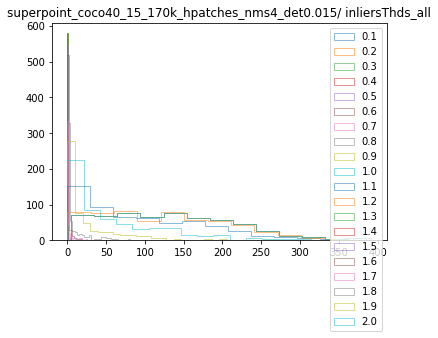

plot:  matchesThds_all


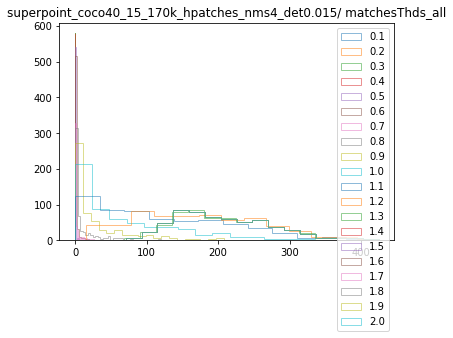

plot:  p_inliers_all


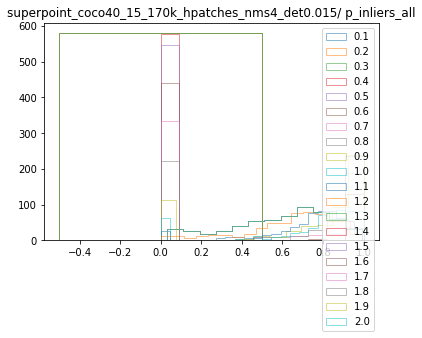

In [15]:
def plotHist(vect, title='untitled', label='', range=None, plot=True):
    import matplotlib.pyplot as plt
    rng = np.random.RandomState(10)  # deterministic random data
#     a = np.hstack((rng.normal(size=1000),
#                    rng.normal(loc=5, scale=2, size=1000)))
    plt.hist(vect, bins='auto', alpha=0.5, histtype=u'step', range=range, label=label)  # arguments are passed to np.histogram
    plt.title(title)
    pass

plot_task = ['inliersThds_all', 'matchesThds_all', 'p_inliers_all']
# plot_task = ['p_inliers_all']
    
# plot the histograms
for folder in folders:
    exp_results = inliers_exp[folder]
    # all inliers
#     print(list(exp_results))
    # get number of inliers under different scores
    def plotTask(task):
        print("plot: ", task)
        inliersThds_all = exp_results[task]
        inliersThds_all = np.array(inliersThds_all)
    #     print("inliersThds_all: ", inliersThds_all.shape)
        for i in range(inliersThds_all.shape[1]):
            plotHist(inliersThds_all[:,i], label=str(threshs[i]), title=folder + "/ " + task)
        plt.legend(loc='upper right')
        plt.show()
    # plot histograms
    for task in plot_task:
        plotTask(task)
    

## matching score

folder:  superpoint_coco40_15_170k_hpatches_nms4_det0.015
num_points_shared:  (580, 1)
inliersThds_all:  (580, 20)
mscore_m:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03602942e-05
 4.48625494e-04 3.26124666e-03 1.17885498e-02 3.55604519e-02
 8.72992789e-02 1.78964613e-01 2.87899921e-01 3.65574456e-01
 3.88696940e-01 3.88734048e-01 3.88734048e-01 3.88734048e-01
 3.88734048e-01 3.88734048e-01 3.88734048e-01 3.88734048e-01]
mscore:  [[0.         0.         0.         ... 0.18899522 0.18899522 0.18899522]
 [0.         0.         0.         ... 0.25968992 0.25968992 0.25968992]
 [0.         0.         0.         ... 0.63874346 0.63874346 0.63874346]
 ...
 [0.         0.         0.         ... 0.27242525 0.27242525 0.27242525]
 [0.         0.         0.         ... 0.56453559 0.56453559 0.56453559]
 [0.         0.         0.         ... 0.74812968 0.74812968 0.74812968]]
num_points_shared:  [339.60172414]
inliersThds_all:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.44827586e-03
 

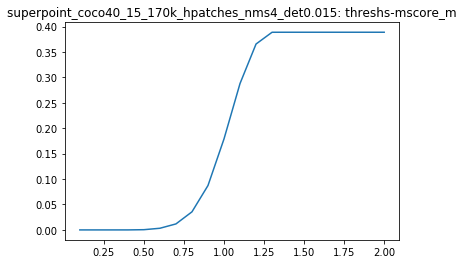

In [16]:
titles = ['keypoints', 'warped_keypoints', 'unwarped_keypoints', 
          'average over keypoints and unwarped keypoints']

for folder in folders:
#     f_idx = folder 
    print("folder: ", folder)
    num_points = all_num_points[f_idx]
    num_points_shared = num_points[:,3] # get points in shared region
    num_points_shared = num_points_shared[:,np.newaxis]
    num_points_shared[num_points_shared == 0] = 1
    print("num_points_shared: ", num_points_shared.shape)    
    exp_results = inliers_exp[folder]
    inliersThds_all = exp_results['inliersThds_all']
    inliersThds_all = np.array(inliersThds_all)
    print("inliersThds_all: ", inliersThds_all.shape)
    mscore = inliersThds_all/num_points_shared
    mscore_m = mscore.mean(axis=0)
    print("mscore_m: ", mscore_m)
    print("mscore: ", mscore)
    print("num_points_shared: ", num_points_shared.mean(axis=0))    
    print("inliersThds_all: ", inliersThds_all.mean(axis=0))
    
    # plot curve
    plt.plot(threshs, mscore_m)
    plt.title(folder + ": threshs-mscore_m")
    plt.show()
    

In [17]:
# plot mscore_m - threshs


mscores_all:  580
mscores_all:  (175, 3)
inliers_all:  (175,)
threshs:  [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
folder:  superpoint_coco40_15_170k_hpatches_nms4_det0.015
mAP under thd [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ] = [0.         0.         0.         0.00344828 0.05862069 0.23482656
 0.40558655 0.57905532 0.72764283 0.77903487 0.78069811 0.74917018
 0.73153206 0.73149209 0.73149209 0.73149209 0.73149209 0.73149209
 0.73149209 0.73149209]


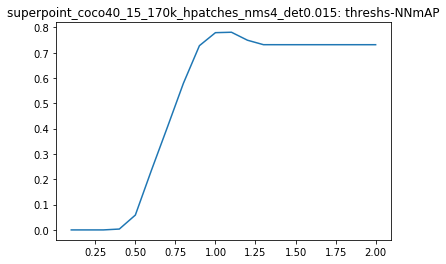

In [18]:
def computeAP(m_test, m_score, verbose=False):
    from sklearn.metrics import average_precision_score

    average_precision = average_precision_score(m_test, m_score)
    if verbose:
        print('Average precision-recall score: {0:0.2f}'.format(
        average_precision))
    return average_precision

def selectwThd(m_score, inliers, thd=0.8):
    mask = m_score < thd
    # m_score_mask = np.select([mask])
    m_score_mask = m_score[mask,]
    inliers = inliers[mask,]
    return m_score_mask, inliers
    

def flipArr(arr):
    return arr.max() - arr


print("mscores_all: ", len(mscores_all))
print("mscores_all: ", mscores_all[0].shape)
print("inliers_all: ", inliers_all[0].shape)

thds = threshs
print("threshs: ", thds)
seq_len = len(inliers_all)
average_precision = np.zeros((seq_len, len(thds)))

for folder in folders:
    exp_results = inliers_exp[folder]
    mscores_all = exp_results['mscores_all']
    inliers_all = exp_results['inliers_all']
    print("folder: ", folder)
    for i in range(seq_len):
    #     i = 0
        inliers = inliers_all[i]
#         print("% of inliers: ", inliers.sum()/inliers.shape[0])
        m_score = mscores_all[i][:,2]
        # filter using thd
        for j in range(len(thds)):
            thd = thds[j]
            m_flip, m_inliers = selectwThd(m_score, inliers, thd)
            # avoid nan in AP algorthm
            if m_inliers.shape[0] > 0 and m_inliers.sum()>0:
                m_flip = flipArr(m_flip)
                # compute ap
                ap = computeAP(m_inliers, m_flip)
            else:
                ap = 0
            average_precision[i,j] = ap

    print("mAP under thd {} = {}".format(thds, average_precision.mean(axis=0)))
    # plot mscore_m - threshs
    plt.plot(threshs, average_precision.mean(axis=0))
    plt.title(folder + ": threshs-NNmAP")
    plt.show()

In [19]:
def plotAP(y_test, y_score, ap):

    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from sklearn.utils.fixes import signature

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              ap))
    plt.show()
    
# thd = 1.5
# mask = m_score < thd
# m_score = max(0., thd - m_score)
# plotAP(inliers, m_score, ap)

test thd:  0.7


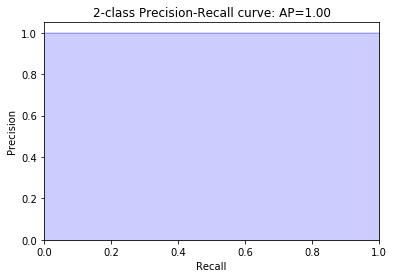

test thd:  0.8


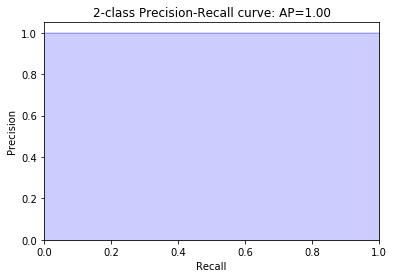

test thd:  0.9


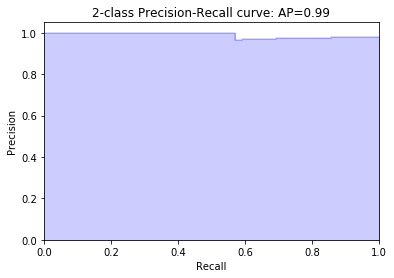

test thd:  1.0


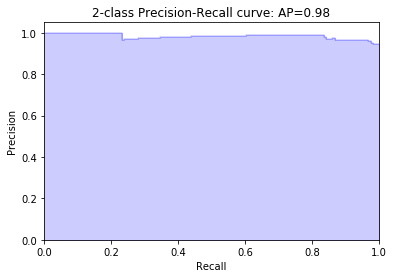

test thd:  1.2


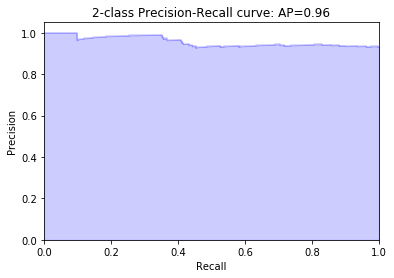

In [20]:
def selectwThd(m_score, inliers, thd=0.8):
    mask = m_score < thd
    # m_score_mask = np.select([mask])
    m_score_mask = m_score[mask,]
    inliers = inliers[mask,]
    return m_score_mask, inliers
    

def flipArr(arr):
    return arr.max() - arr

# test one image in different threshold
thds = [0.7, 0.8, 0.9, 1.0, 1.2]
for thd in thds:
    print("test thd: ", thd)
    m_flip, m_inliers = selectwThd(m_score, inliers, thd)
    #  = selectwThd(inliers, thd)
    m_flip = flipArr(m_flip)
    if verbose:
        print("m_flip: ", m_flip)
        print("m_inliers: ", m_inliers)

        print("m_score: ", m_score.shape)
        print("m_score: ", m_score)
        print("mask: ", mask.sum())
        print("m_score_mask: ", m_score_mask.shape)

    ap = computeAP(m_inliers, m_flip)
    plotAP(m_inliers, m_flip, ap)

## Testing code

In [21]:
my_dict = {}
my_dict.update({'image': np.zeros(10)})
list(inliers_exp)

['superpoint_coco40_15_170k_hpatches_nms4_det0.015']

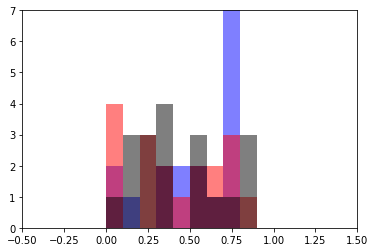

In [22]:
import matplotlib.pyplot as plt
import numpy as np

x = np.random.random(20)
y =np.random.random(20)
z= np.random.random(20)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(x, bins=np.arange(0, 1, 0.1), ls='dashed', alpha = 0.5, lw=3, color= 'b')
ax.hist(y, bins=np.arange(0, 1, 0.1), ls='dotted', alpha = 0.5, lw=3, color= 'r')
ax.hist(z, bins=np.arange(0, 1, 0.1), alpha = 0.5, lw=3, color= 'k')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0, 7)
plt.show()

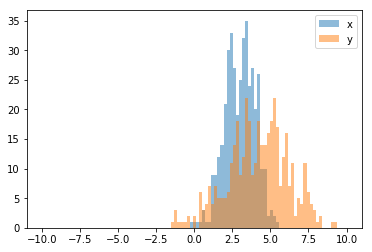

In [23]:
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()